In [1]:
%cd ~/github/agn_lf/
# %cd ..
import source.astro_functions as af
import source.table_functions as tf
import source.lf_xi2 as xi2
import source.vmax as vmax
import source.utils as utils
import numpy as np
from scipy.interpolate import interp1d as intp
import matplotlib.pyplot as plt
from astropy.io import fits
import astropy.table as table
import astropy.units as u
import source.selection_criteria as sc
from sklearn.neighbors import KernelDensity

/Users/runburg/github/agn_lf


In [2]:
# catalog = table.Table.read('./data/master_cat_irac3_mips24')
catalog = table.Table.read('./data/help_full_catalog_with_fluxes_and_redshifts.fits')
outfile = 'lf_ir'
specz = 'zspec' 
# photoz = 'z1_median'
photoz = 'redshift'
truncate_radec = 1
label = 'Full HELP sample'

specz_only = True
if specz_only is True:
    outfile = 'lf_ir_specz_only'
    label = 'Only specz'

xmatch = False
xray_select = False
gaussian_uncertainty = False

if xmatch is True:
    catalog = table.Table.read('./data/xmatch_catalog_1_arcsec.fits')
#     print(catalog.colnames)
#     catalog = table.Table.read('./data/ir_and_xray.fits')
    outfile = 'lf_ir_crossmatch_ir_selected'
    specz = 'zspec_1'
    # specz = 'redshift'
    # photoz = 'ZPHOT'
    photoz = 'redshift'
    label = 'Crossmatch, IR selected'
    if xray_select is True:
        outfile = 'lf_ir_crossmatch_xray_selected'
        label = 'Crossmatch, X-ray selected'

    ra_up = 36.5
    ra_down = 34.25
    dec_up = -4.0
    dec_down = -5.5
    catalog = catalog[(ra_down < catalog['RA_2']) & (catalog['RA_2'] < ra_up)& (dec_down < catalog['DEC_2']) & (catalog['DEC_2'] < dec_up)]
    truncate_radec = [ra_down, ra_up, dec_down, dec_up]

if gaussian_uncertainty is True:
    outfile += '_gaussian_uncertainty'
# coverage
field_coverage_area = 8.9
if xmatch is True:
    field_coverage_area = (ra_up - ra_down) * (dec_up - dec_down)

######
flux36 = 'f_ap_irac_i1'
flux45 = 'f_ap_irac_i2'
flux58 = 'f_ap_irac_i3'
flux80 = 'f_ap_irac_i4'
flux240 = 'f_mips_24'

# print(catalog[flux58][catalog[flux58] < 0])
never_nan = (np.nan_to_num(catalog[flux58], nan=-99) > 0) & (np.nan_to_num(catalog[flux80], nan=-99) > 0) #& (np.nan_to_num(catalog[specs], nan=-99) > 0)

selected_agn = sc.select_ir(catalog[never_nan], flux36, flux45, flux58, flux80, selection_cuts='lacy05')
ct_lacy = catalog[never_nan][selected_agn]

if xray_select is True and xmatch is True:
    ct_lacy = catalog[np.nan_to_num(catalog[flux58], nan=-99) > 0]

cat_lacy = ct_lacy[(np.nan_to_num(ct_lacy[photoz], nan=-99) > 0 ) | (np.nan_to_num(ct_lacy[specz], nan=-99) > 0)]
# full_fluxes = cat_lacy
full_fluxes = catalog[never_nan]

# for specz only
if specz_only is True:
    ct_lacy = cat_lacy[np.nan_to_num(cat_lacy[specz], nan=-99) > 0]
else:
    ct_lacy = cat_lacy


cosmo = af.setup_cosmology()

print('Number of objects in catalog', len(catalog))
print('Number of AGN selected', len(ct_lacy))
# 5914
# 1108

Number of objects in catalog 18328
Number of AGN selected 2283


In [3]:
print(np.sum(np.nan_to_num(catalog[photoz], nan=-99) > 0),np.sum(np.nan_to_num(catalog[specz], nan=-99) > 0))
# sources = ct_lacy[photoz] < 1.5
# ratio = ct_lacy[sources][flux58]/ct_lacy[sources]['FB_FLUX']
# plt.scatter(ct_lacy[sources][flux58], ratio, alpha=0.5)
# plt.xscale('log')
# plt.yscale('log')

17943 5500


In [4]:
# ct_lacy.colnames

In [5]:
# sample parameters
z_sample_min = 0.5
z_sample_max = 4
l_sample_min = 2e43
l_sample_max = 3e46

# bins
num_bins_z = 10
num_bins_l = 15
# redshift range 
z_bins = np.logspace(np.log10(z_sample_min), np.log10(z_sample_max), num=num_bins_z)
# print(z_bins)
l_bins = np.logspace(np.log10(l_sample_min), np.log10(l_sample_max), num=num_bins_l)


# band + units
wavelength = 5.8
unit_conversion = 3 / wavelength * 1e-15
flux_limit = 43 * unit_conversion

# K-correction
spectral_index = np.log10(ct_lacy[flux240].data/ct_lacy[flux58].data) / np.log10(24/5.8)
# full_spectral_index = np.log10(full_fluxes[flux240].data/full_fluxes[flux58].data) / np.log10(24/5.8)

# Uncertainties and corrections
goodzs = (ct_lacy[photoz] > 0) & (ct_lacy[specz] > 0)
# full_fluxes = full_fluxes[(z_sample_min < z) & (z_sample_max > z)]

kds = []
for i in np.arange(len(z_bins)-1):
    inbin = (ct_lacy[photoz][goodzs] > z_bins[i]) & (ct_lacy[photoz][goodzs] < z_bins[i+1])
    kde = KernelDensity(bandwidth=0.1, kernel='gaussian')
    kde.fit(ct_lacy[specz][goodzs][inbin][:, None])
    
    kds.append(kde)

image_file = './data/chen2018-xmmlss-data-products-2018-06-08/xexp_merged.full.v01.fits'
wcs, hdu = utils.load_wcs(image_file)
cov_function = vmax.coverage_function(hdu.data, wcs, 3824, 2694, detector_area=36, photon_energy=7e-9, truncate_radec=truncate_radec)

bolo_corr = 1
# bolo_corr = 8
# ct_lacy['random_z'] = 0#ct_lacy[photoz]

if specz_only is True:
    with np.load('./data/incompleteness_corrections_mag_specz_only.npz') as f:
        mags = f['mags']
        corrs = f['corrs']
        f_corr = f['fluxes']
elif xmatch is True:
    with np.load('./data/incompleteness_corrections_mag_crossmatch.npz') as f:
        mags = f['mags']
        corrs = f['corrs']
        f_corr = f['fluxes']
else:
    with np.load('./data/incompleteness_corrections_mag.npz') as f:
        mags = f['mags']
        corrs = f['corrs']
        f_corr = f['fluxes']

corr_fn = intp(f_corr, corrs, bounds_error=False, fill_value=1) 
# MCMC runs
N = 10000

if specz_only is True:
    N = 1


WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 35.5  -4.8  
CRPIX : 1969.0  1267.0  
CD1_1 CD1_2  : -0.001111111111111  0.0  
CD2_1 CD2_2  : 0.0  0.001111111111111  
NAXIS : 3824  2694


/Users/runburg/github/agn_lf/source/vmax.py:223: RuntimeWarning: divide by zero encountered in true_divide
  fluxes = 1/(data[:-1, :-1] * truncate_radec).flatten()


The total coverage is 8.85230357595602 square degrees.


In [6]:
import time
start_time = time.time()
lf_chain = np.zeros((N, num_bins_z-1, num_bins_l-1))
# lf_err_chain = lf_chain[:]
corrfnss = []

for i in range(N):
    if i % 50 == 0:
        print('progress', round(i/N * 100, 2), '%')
    
    randomz = np.zeros(len(ct_lacy))
    ct_lacy['random_z'] = randomz
#     ### use zphot - zspec to estimate uncertainty on z
#     for j in np.arange(len(z_bins) - 1):
#         inbin = (ct_lacy[photoz][goodzs] >= z_bins[j]) & (ct_lacy[photoz][goodzs] < z_bins[j+1])
# #         histo, bin_edges = np.histogram(difs[inbin], bins=200)
#         histo, bin_edges = np.histogram(difs[inbin], bins=200)

#         photoz_inbin = (ct_lacy[photoz] >= z_bins[j]) & (ct_lacy[photoz] < z_bins[j+1])
#         randomz[photoz_inbin] = ct_lacy[photoz][photoz_inbin] - np.random.choice((bin_edges[:-1]), size=np.sum(photoz_inbin), p=histo/np.sum(histo))
        
#         while np.any(randomz < 0):
#             indices = randomz < 0
#             randomz[indices] = ct_lacy[photoz][indices] - np.random.choice((bin_edges[:-1]), size=np.sum(indices), p=histo/np.sum(histo))
# #         ct_lacy['random_z'][photoz_inbin] = ct_lacy[photoz][photoz_inbin]
    if gaussian_uncertainty is False:
        for j, kd in enumerate(kds):
            photoz_inbin = (ct_lacy[photoz] >= z_bins[j]) & (ct_lacy[photoz] < z_bins[j+1])
            randomz[photoz_inbin] = kd.sample(np.sum(photoz_inbin)).flatten()

        ct_lacy['random_z'] = randomz
    else:
        nonzerophotoz = (ct_lacy[photoz] >= 0)
        means = ct_lacy[photoz]
        sigmas = 0.2 * (1 + means)
        ct_lacy['random_z'] = np.random.normal(means, sigmas)
        
    z = np.array([row[specz] if row[specz] > 0 else row['random_z'] for row in ct_lacy])   
    ###
    
    l = 4 * np.pi * cosmo.luminosity_distance(z).to(u.cm).value.astype(np.float64)**2 * ct_lacy[flux58].data * unit_conversion * (1 + z)**(-1 + spectral_index) * bolo_corr
    
    good_redshift_and_l_selected = (l_sample_min < l) & (l_sample_max > l) & (z_sample_min < z) & (z_sample_max > z)
    l = l[good_redshift_and_l_selected]
    z = z[good_redshift_and_l_selected]
#     print(1, time.time() - start_time)
    
    
#     fullz = np.array([row[specz] if row[specz] > 0 else row[photoz] for row in full_fluxes])   
#     fulll = 4 * np.pi * cosmo.luminosity_distance(fullz).to(u.cm).value**2 * full_fluxes[flux58].data * unit_conversion * (1 + fullz)**(-1 + full_spectral_index) * bolo_corr
#     coverage_correction = vmax.coverage_correction(full_fluxes[(l_sample_min < fulll) & (l_sample_max > fulll) & (z_sample_min < fullz) & (z_sample_max > fullz)][flux58], ct_lacy[flux58][good_redshift_and_l_selected])
    coverage_correction = vmax.coverage_correction(cat_lacy[flux58], ct_lacy[flux58][good_redshift_and_l_selected])
#     coverage_correction = vmax.coverage_correction(catalog[never_nan][selected_agn][flux58], ct_lacy[flux58][good_redshift_and_l_selected])
#     coverage_correction = vmax.coverage_correction(full_fluxes[flux58], ct_lacy[flux58][good_redshift_and_l_selected])
#     print(2, time.time() - start_time)
    
#     coverage_correction = lambda x: 1
#     print(coverage_correction(np.mean(ct_lacy[flux58])+2*np.std(ct_lacy[flux58])))
    zmax = vmax.compute_zmax(l, z, cosmo, flux_limit, zspacing=0.5, jack_version=False, output=False)
    zmin = np.array([0]*len(zmax))
#     print(3, time.time() - start_time)

    def corrected_cov_func(l, z):
        flux = l / (4 * np.pi * cosmo.luminosity_distance(z).to(u.cm).value**2)
        
        if np.any(coverage_correction(flux) < 1e-1):
            print(coverage_correction(flux))
        if xmatch is True:
            return cov_function(flux) * coverage_correction(flux) * corr_fn(flux / unit_conversion)
        
#         corr_fn = lambda x: 1
#         corrfnss.append(corr_fn(flux/unit_conversion))
        return field_coverage_area * coverage_correction(flux) * corr_fn(flux / unit_conversion)
#         return field_coverage_area * corr_fn(flux / unit_conversion)

    vmax_vals = vmax.compute_binned_vmax_values(l, (z, zmin, zmax), l_bins, z_bins, cosmo, bin_z_bounds=False, coverage=corrected_cov_func)
#     print(4, time.time() - start_time)
    
    lf_vals, lf_errs = vmax.compute_lf_values(l, z, vmax_vals, z_bins, l_bins, poisson_error=False)
#     print(5, time.time() - start_time)
    
    lf_chain[i] = lf_vals
#     lf_err_chain[i] = lf_errs
    
print(total_time := time.time() - start_time, total_time/N)
# print(np.mean(corrfnss))

progress 0.0 %
0.3495481014251709 0.3495481014251709


/Users/runburg/github/agn_lf/source/vmax.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(lf), np.array(errors)


In [7]:
corr_fn(100), corrfnss

(array(0.15801794), [])

In [8]:
sorted_lf = np.sort(lf_chain, axis=0)
# probs = np.cumsum(sorted_lf, axis=0)
# probs /= probs[-1]
# probs = np.nan_to_num(probs)
# print(probs)
mid_id = len(sorted_lf) // 2
high_id = (len(sorted_lf) * 84) // 100
low_id = (len(sorted_lf) * 16) // 100
print(low_id, mid_id, high_id, len(sorted_lf))

sh = sorted_lf.shape
median_vals = np.zeros((sh[1], sh[2]))
med_errs = np.zeros((sh[1], 2, sh[2]))
# low_errs = np.zeros((sh[1], sh[2]))
for i in range(sh[1]):
    for j in range(sh[2]):
        bin_results = sorted_lf[:, i, j][sorted_lf[:, i, j] > 0]
        if len(bin_results) < 1:
            median_vals[i, j] = 0
            med_errs[i, :, j] = [0, 0]
            continue
        mid_id = len(bin_results) // 2
        high_id = (len(bin_results) * 84) // 100
        low_id = (len(bin_results) * 16) // 100
        
        median_vals[i, j] = bin_results[mid_id]
        med_errs[i, 1, j] = bin_results[high_id] - median_vals[i, j]
        med_errs[i, 0, j] = median_vals[i, j] - bin_results[low_id]
        
        
# print(median_vals)

0 0 0 1


In [9]:
z = np.array([row[specz] if row[specz] > 0 else row[photoz] for row in ct_lacy])
l = 4 * np.pi * cosmo.luminosity_distance(z).to(u.cm).value.astype(np.float64)**2 * ct_lacy[flux58].data * unit_conversion * (1 + z)**(-1 + spectral_index) * bolo_corr
# for zz, flux, spectral_indexx in zip(z, ct_lacy[flux58], spectral_index):
#     l = 4 * np.pi * cosmo.luminosity_distance(zz).to(u.cm).value**2 * flux.data * unit_conversion * (1 + zz)**(-1 + spectral_indexx) * bolo_corr
#     if l == np.inf:
#         print(zz, flux, spectral_indexx)
# print(l)
# print(z.min(), z.max(), l.argmax(), cosmo.luminosity_distance(z).to(u.cm).value.max())
poi_lower, poi_upper = vmax.poisson_errors(l, z, l_bins, z_bins)
# print(poi_upper)
for i in range(sh[1]):
    for j in range(sh[2]):
#         print(poi_upper[i, j], poi_lower[i, j])
        med_errs[i, 1, j] = np.sqrt(med_errs[i, 1, j]**2 + (median_vals[i, j] * poi_upper[i, j])**2)
        med_errs[i, 0, j] = np.sqrt(med_errs[i, 0, j]**2 + (median_vals[i, j] * poi_lower[i, j])**2)
        if np.any(poi_upper[i, j] == 0):
            median_vals[i, j] = 0
        
# print(med_errs[:, 1, :])

In [10]:
print(sorted_lf[0, 3 ,1], med_errs[3, :, 1], median_vals[3,1])
np.allclose(sorted_lf[:, 3, 1], sorted_lf[0, 3 ,1])

1.8840200227068576e-46 [1.55808456e-46 4.33324605e-46] 1.8840200227068576e-46


True

In [11]:
hz_convert = 5.8e-6 / 3e8
lit_data = {}
other_limits = {}
lacy_ir_evol_params_central = {'A': 10**-4.75, 
                               'gamma1':1.07, 
                               'gamma2':2.48,
                               'Lstar': 10**31.92 / hz_convert,
                               'zref':2.5,
                               'k1':1.05,
                               'k2':-4.71,
                               'k3':-0.034
                              }
lacy_ir_evol_params_max = {'A': 10**-4.73, 
                               'gamma1':1.13, 
                               'gamma2':2.53,
                               'Lstar': 10**31.94 / hz_convert,
                               'zref':2.5,
                               'k1':1.08,
                               'k2':-4.58,
                               'k3':0.156
                              }
lacy_ir_evol_params_min = {'A': 10**-4.77, 
                               'gamma1':1.01, 
                               'gamma2':2.43,
                               'Lstar': 10**31.9 / hz_convert,
                               'zref':2.5,
                               'k1':1.02,
                               'k2':-4.84,
                               'k3':-0.224
                              }

center_zbins = (z_bins[1:] + z_bins[:-1]) / 2
ls = np.logspace(43, 47.0, num=50)
lacy_limits = [[44, 46], [44, 46], [44.5, 46.5], [44.5, 46.5], [45, 46.5], [46, 46.5], [46, 46.5], [46.5, 46.5], [46.5, 46.5]]
lacy_mid = af.IR_evol(ls, center_zbins, **lacy_ir_evol_params_central)
lacy_high = af.IR_evol(ls, center_zbins, **lacy_ir_evol_params_max)
lacy_low = af.IR_evol(ls, center_zbins, **lacy_ir_evol_params_min)
# print(lacy_mid[0])
lit_data['Lacy 2015'] = list(zip(lacy_mid, lacy_high, lacy_low))
other_limits['Lacy 2015'] = 10**np.array(lacy_limits)
# lacy_mid[1][:10]

In [21]:
np.savez('./output/' + outfile + '.npz', lf_vals=median_vals, lf_errs=med_errs, z_bins=z_bins, l_bins=l_bins)
# plot_files = ['./output/lf_ir_montecarlo.npz']

plot_files = ['./output/lf_ir.npz', './output/lf_ir_crossmatch_xray_selected.npz', './output/lf_ir_gaussian_uncertainty.npz']#,'./output/lf_ir_crossmatch_ir_selected.npz']

labs = ['Full HELP catalog', 'Crossmatch, X-ray selected']#, 'Gaussian uncertainty']
otherruns = {}
for lab, fil in zip(labs, plot_files):
    with np.load(fil) as infile:
        lfv = infile['lf_vals']
        lfe = infile['lf_errs']
    otherruns[lab] = [lfv, lfe]


/Users/runburg/github/agn_lf/source/vmax.py:270: UserWarning: FixedFormatter should only be used together with FixedLocator
  axflat[i].set_xticklabels(np.log10(axflat[i].get_xticks()).astype(int))
/Users/runburg/github/agn_lf/source/vmax.py:270: UserWarning: FixedFormatter should only be used together with FixedLocator
  axflat[i].set_xticklabels(np.log10(axflat[i].get_xticks()).astype(int))
/Users/runburg/github/agn_lf/source/vmax.py:270: UserWarning: FixedFormatter should only be used together with FixedLocator
  axflat[i].set_xticklabels(np.log10(axflat[i].get_xticks()).astype(int))
/Users/runburg/github/agn_lf/source/vmax.py:270: UserWarning: FixedFormatter should only be used together with FixedLocator
  axflat[i].set_xticklabels(np.log10(axflat[i].get_xticks()).astype(int))
/Users/runburg/github/agn_lf/source/vmax.py:270: UserWarning: FixedFormatter should only be used together with FixedLocator
  axflat[i].set_xticklabels(np.log10(axflat[i].get_xticks()).astype(int))
/Users/run

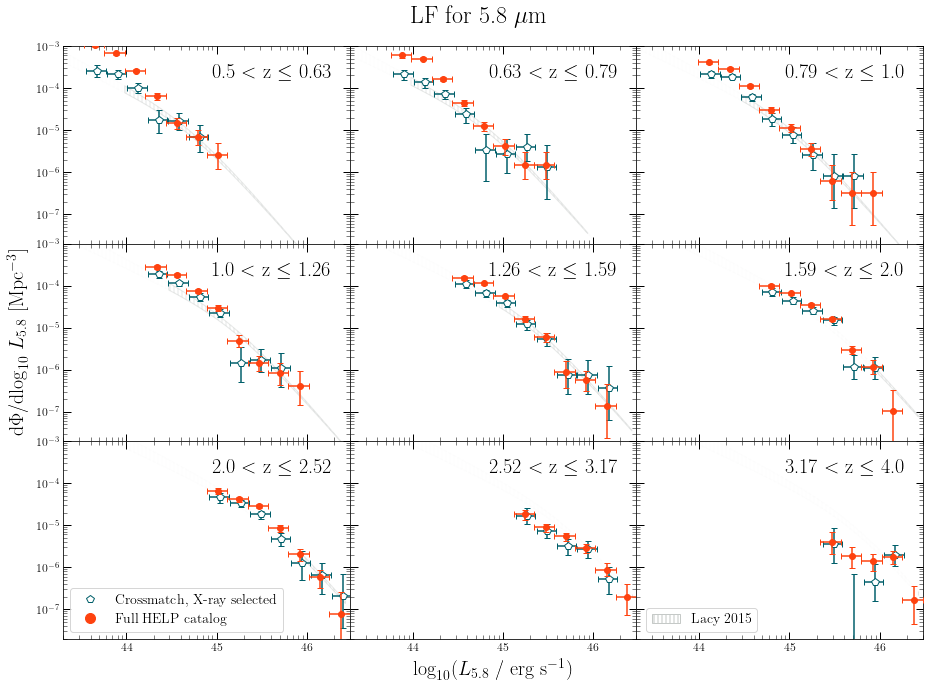

In [22]:
import importlib
importlib.reload(vmax)

# np.savez('./output/lf_ir_crossmatch_xrayselected_montecarlo.npz', lf_vals=median_vals, lf_errs=med_errs)

# print(median_vals)

main_results = otherruns.pop(labs[0])

outfile = 'lf_ir_xmatch'

l_limits = 4 * np.pi * cosmo.luminosity_distance((z_bins[:-1]+z_bins[1:])/2)**2 * flux_limit/(u.cm**2)
l_limits = l_limits.decompose()
fig, axs, big_ax = vmax.plot_lf_vmax(main_results[0], main_results[1], z_bins, l_bins, compare_to_others=lit_data, other_runs=otherruns, title=r'LF for 5.8 $\mathrm{\mu m}$', others_limits=other_limits, lum_limits=l_limits, this_label=labs[0], outfile='./output/paper_plots/' + outfile + '.pdf', lum_sublabel=r'_{5.8}')

/Users/runburg/github/agn_lf/source/vmax.py:270: UserWarning: FixedFormatter should only be used together with FixedLocator
  axflat[i].set_xticklabels(np.log10(axflat[i].get_xticks()).astype(int))
/Users/runburg/github/agn_lf/source/vmax.py:270: UserWarning: FixedFormatter should only be used together with FixedLocator
  axflat[i].set_xticklabels(np.log10(axflat[i].get_xticks()).astype(int))
/Users/runburg/github/agn_lf/source/vmax.py:270: UserWarning: FixedFormatter should only be used together with FixedLocator
  axflat[i].set_xticklabels(np.log10(axflat[i].get_xticks()).astype(int))
/Users/runburg/github/agn_lf/source/vmax.py:270: UserWarning: FixedFormatter should only be used together with FixedLocator
  axflat[i].set_xticklabels(np.log10(axflat[i].get_xticks()).astype(int))
/Users/runburg/github/agn_lf/source/vmax.py:270: UserWarning: FixedFormatter should only be used together with FixedLocator
  axflat[i].set_xticklabels(np.log10(axflat[i].get_xticks()).astype(int))
/Users/run

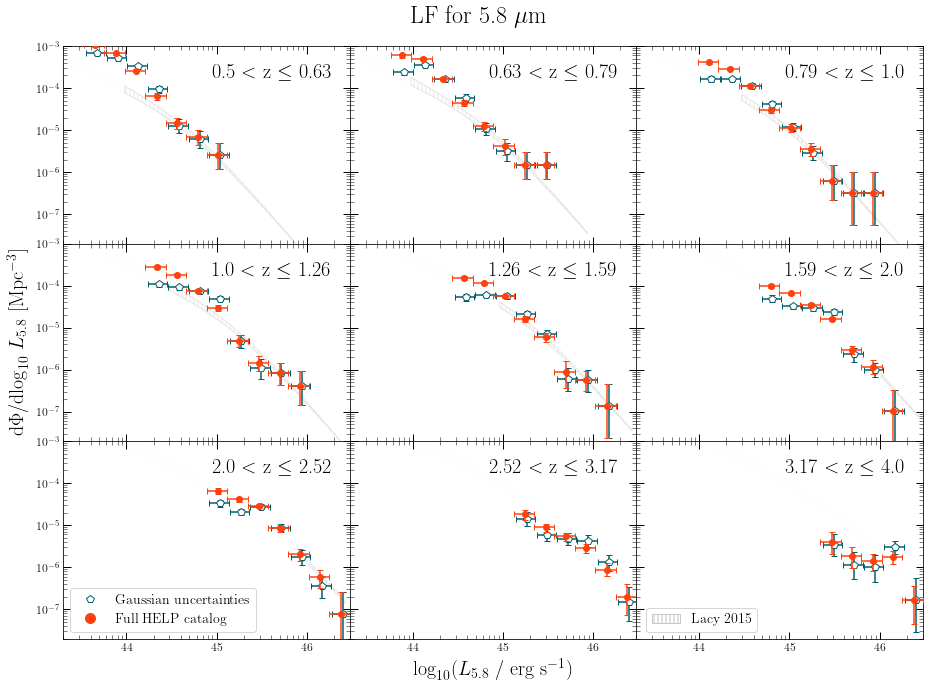

In [14]:
# plot_files = ['./output/lf_ir_montecarlo.npz']

plot_files = ['./output/lf_ir.npz', './output/lf_ir_gaussian_uncertainty.npz']#,'./output/lf_ir_crossmatch_ir_selected.npz']

labs = ['Full HELP catalog', 'Gaussian uncertainties']
otherruns = {}
for lab, fil in zip(labs, plot_files):
    with np.load(fil) as infile:
        lfv = infile['lf_vals']
        lfe = infile['lf_errs']
    otherruns[lab] = [lfv, lfe]


import importlib
importlib.reload(vmax)

# np.savez('./output/lf_ir_crossmatch_xrayselected_montecarlo.npz', lf_vals=median_vals, lf_errs=med_errs)

# print(median_vals)

main_results = otherruns.pop(labs[0])

outfile = 'lf_ir_gaussian_uncertainties'

l_limits = 4 * np.pi * cosmo.luminosity_distance((z_bins[:-1]+z_bins[1:])/2)**2 * flux_limit/(u.cm**2)
l_limits = l_limits.decompose()
fig, axs, big_ax = vmax.plot_lf_vmax(main_results[0], main_results[1], z_bins, l_bins, compare_to_others=lit_data, other_runs=otherruns, title=r'LF for 5.8 $\mathrm{\mu m}$', others_limits=other_limits, lum_limits=l_limits, this_label=labs[0], outfile='./output/paper_plots/' + outfile + '.pdf', lum_sublabel=r'_{5.8}')

In [15]:
# main_results[0][5][2] = 0

In [16]:
redbin = 6
l_bin = 6
lacy_index = 11
lum = l_bins[l_bin:l_bin+2].mean()
ourvalue = main_results[0][redbin][l_bin] * np.log(10) * lum
print(lum)
ourerror = main_results[1][redbin, 1, l_bin]*np.log(10)*lum
print(main_results[0][redbin] * np.log(10)*lum)
# lacyval = lacy_mid[redbin1]
# lacylow = lacy_low[redbin][lacy_index][1]
from scipy.interpolate import interp1d
lacyval = interp1d(lacy_mid[redbin, :, 0], lacy_mid[redbin, :, 1])
lacylow = interp1d(lacy_low[redbin, :, 0], lacy_low[redbin, :, 1])
print(f'our val {ourvalue:.6f} +/- {np.abs(ourerror - ourvalue):.6f} \t lacy val {lacyval(lum):.6f} +/- {np.abs(lacyval(lum) - lacylow(lum)):.6f}')
print('redshifts', z_bins[redbin],  '< z <', z_bins[redbin+1])
# print('our lum', l_bins[l_bin:l_bin+2].mean(), '\t lacy lum', lacy_mid[redbin][lacy_index][0])
rez = np.abs(lacyval(lum) - ourvalue)
rezerr = np.sqrt((ourerror - ourvalue)**2 + (lacylow(lum) - lacyval(lum))**2)
print('agreement with lacy', rez, '+/-', rezerr)
print('sigma significance', rez/rezerr)

6.1700942757292904e+44
[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 3.22918469e-06 2.52698338e-04 3.88156032e-05
 1.44852846e-05 6.05233564e-06 1.04989891e-06 1.47258782e-07
 2.50612555e-08 2.00122038e-09]
our val 0.000253 +/- 0.000061 	 lacy val 0.000121 +/- 0.000023
redshifts 2.0 < z < 2.5198420997897464
agreement with lacy 0.0001314466217646767 +/- 6.510505573355663e-05
sigma significance 2.018992538807184


In [17]:
bin_centers = (l_bins[1:] + l_bins[:-1]) / 2
for redbin in range(len(z_bins)-1):
# lacy_index = 11
    l_bin = np.argmax((main_results[0][redbin] > 0) & (bin_centers > l_limits[redbin]))
#     print(l_bin)
    lum = l_bins[l_bin:l_bin+2].mean()
    ourvalue = main_results[0][redbin][l_bin]* np.log(10) * bin_centers[redbin]
    ourerror = main_results[1][redbin, 1, l_bin]*np.log(10)*bin_centers[redbin]
#     print(ourvalue)
    # lacyval = lacy_mid[redbin1]
    # lacylow = lacy_low[redbin][lacy_index][1]
    from scipy.interpolate import interp1d
    lacyval = interp1d(lacy_mid[redbin, :, 0], lacy_mid[redbin, :, 1])
    lacylow = interp1d(lacy_low[redbin, :, 0], lacy_low[redbin, :, 1])
    print(f'redshifts {z_bins[redbin]:.2f} < z < {z_bins[redbin+1]:.2f}')
    # print('our lum', l_bins[l_bin:l_bin+2].mean(), '\t lacy lum', lacy_mid[redbin][lacy_index][0])
    rez = np.abs(lacyval(lum) - ourvalue)
    rezerr = np.sqrt((ourerror - ourvalue)**2 + (lacylow(lum) - lacyval(lum))**2)
    print('agreement with lacy', rez, '+/-', rezerr)
    print(f'sigma significance {rez/rezerr:.2f}')
    print('')

redshifts 0.50 < z < 0.63
agreement with lacy 0.0004010793005803964 +/- 0.0005724447595956154
sigma significance 0.70

redshifts 0.63 < z < 0.79
agreement with lacy 0.00016797656675075876 +/- 0.00031920232111015326
sigma significance 0.53

redshifts 0.79 < z < 1.00
agreement with lacy 8.133974258583992e-05 +/- 0.00021959618351892563
sigma significance 0.37

redshifts 1.00 < z < 1.26
agreement with lacy 2.7330987298955424e-05 +/- 0.00015048264280480357
sigma significance 0.18

redshifts 1.26 < z < 1.59
agreement with lacy 2.3495308764751022e-05 +/- 8.24040948990663e-05
sigma significance 0.29

redshifts 1.59 < z < 2.00
agreement with lacy 3.1369163500006595e-05 +/- 5.363085367393812e-05
sigma significance 0.58

redshifts 2.00 < z < 2.52
agreement with lacy 2.618683465351933e-05 +/- 3.425778777368555e-05
sigma significance 0.76

redshifts 2.52 < z < 3.17
agreement with lacy 3.0112435900604182e-05 +/- 1.0065949079249734e-05
sigma significance 2.99

redshifts 3.17 < z < 4.00
agreement with

/Users/runburg/github/agn_lf/source/vmax.py:270: UserWarning: FixedFormatter should only be used together with FixedLocator
  axflat[i].set_xticklabels(np.log10(axflat[i].get_xticks()).astype(int))
/Users/runburg/github/agn_lf/source/vmax.py:270: UserWarning: FixedFormatter should only be used together with FixedLocator
  axflat[i].set_xticklabels(np.log10(axflat[i].get_xticks()).astype(int))
/Users/runburg/github/agn_lf/source/vmax.py:270: UserWarning: FixedFormatter should only be used together with FixedLocator
  axflat[i].set_xticklabels(np.log10(axflat[i].get_xticks()).astype(int))
/Users/runburg/github/agn_lf/source/vmax.py:270: UserWarning: FixedFormatter should only be used together with FixedLocator
  axflat[i].set_xticklabels(np.log10(axflat[i].get_xticks()).astype(int))
/Users/runburg/github/agn_lf/source/vmax.py:270: UserWarning: FixedFormatter should only be used together with FixedLocator
  axflat[i].set_xticklabels(np.log10(axflat[i].get_xticks()).astype(int))
/Users/run

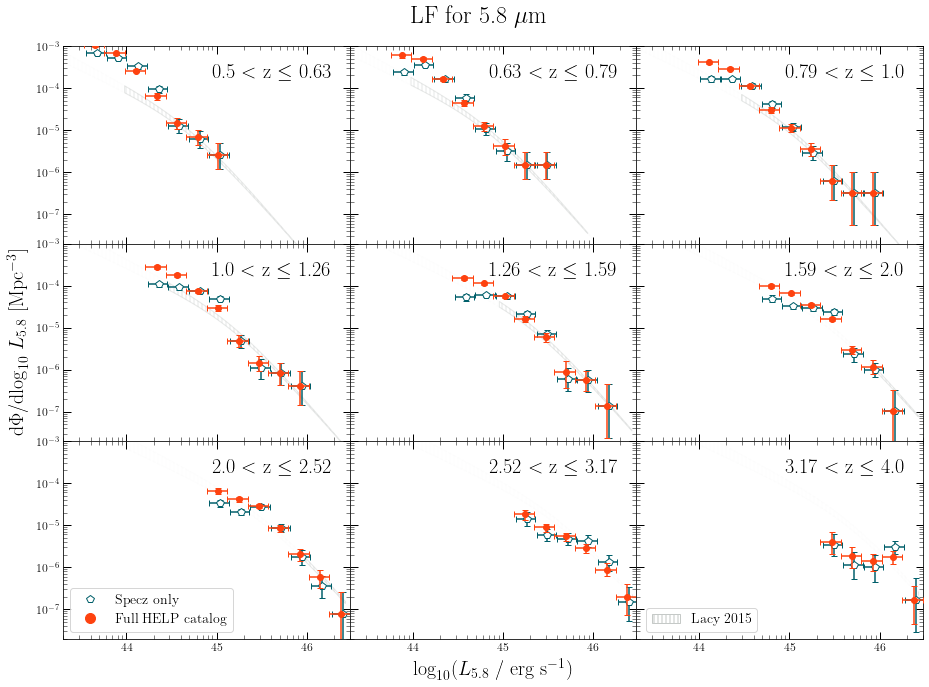

In [18]:
plot_files = ['./output/lf_ir.npz']
labels = ['Full HELP catalog']
mainruns = {}
for lab, fil in zip(labels, plot_files):
    with np.load(fil) as infile:
        lfv = infile['lf_vals']
        lfe = infile['lf_errs']
    mainruns[lab] = [lfv, lfe]
    
plot_files = ['./output/lf_ir_specz_only.npz']
labs = ['Specz only']
otherruns = {}
for lab, fil in zip(labs, plot_files):
    with np.load(fil) as infile:
        lfv = infile['lf_vals']
        lfe = infile['lf_errs']
    otherruns[lab] = [lfv, lfe]

outfile = 'lf_ir_full_vs_specz'
label = 'Full HELP catalog'
fig, axs, big_ax = vmax.plot_lf_vmax(mainruns[labels[0]][0], mainruns[labels[0]][1], z_bins, l_bins, compare_to_others=lit_data, other_runs=otherruns, lum_limits=l_limits, title=r'LF for 5.8 $\mathrm{\mu m}$', others_limits=other_limits, this_label=label, outfile='./output/paper_plots/' + outfile + '.pdf', lum_sublabel=r'_{5.8}')

/Users/runburg/github/agn_lf/source/vmax.py:270: UserWarning: FixedFormatter should only be used together with FixedLocator
  axflat[i].set_xticklabels(np.log10(axflat[i].get_xticks()).astype(int))
/Users/runburg/github/agn_lf/source/vmax.py:270: UserWarning: FixedFormatter should only be used together with FixedLocator
  axflat[i].set_xticklabels(np.log10(axflat[i].get_xticks()).astype(int))
/Users/runburg/github/agn_lf/source/vmax.py:270: UserWarning: FixedFormatter should only be used together with FixedLocator
  axflat[i].set_xticklabels(np.log10(axflat[i].get_xticks()).astype(int))
/Users/runburg/github/agn_lf/source/vmax.py:270: UserWarning: FixedFormatter should only be used together with FixedLocator
  axflat[i].set_xticklabels(np.log10(axflat[i].get_xticks()).astype(int))
/Users/runburg/github/agn_lf/source/vmax.py:270: UserWarning: FixedFormatter should only be used together with FixedLocator
  axflat[i].set_xticklabels(np.log10(axflat[i].get_xticks()).astype(int))
/Users/run

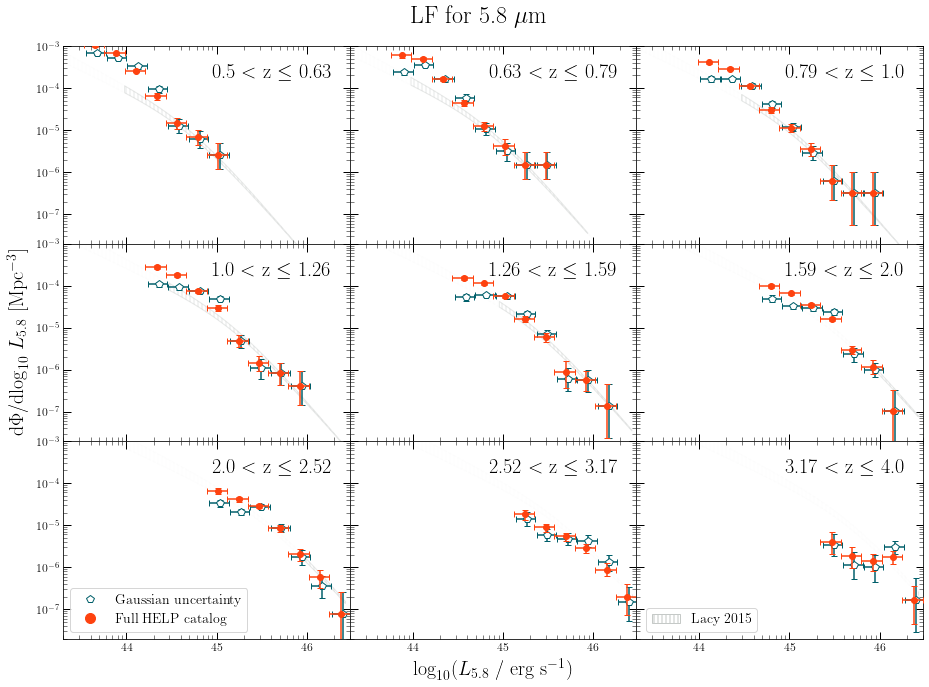

In [19]:
plot_files = ['./output/lf_ir.npz']
labels = ['Full HELP catalog']
mainruns = {}
for lab, fil in zip(labels, plot_files):
    with np.load(fil) as infile:
        lfv = infile['lf_vals']
        lfe = infile['lf_errs']
    mainruns[lab] = [lfv, lfe]
    
plot_files = ['./output/lf_ir_gaussian_uncertainty.npz']
labs = ['Gaussian uncertainty']
otherruns = {}
for lab, fil in zip(labs, plot_files):
    with np.load(fil) as infile:
        lfv = infile['lf_vals']
        lfe = infile['lf_errs']
    otherruns[lab] = [lfv, lfe]

outfile = 'lf_ir_gaussian_uncertainty'
label = 'Full HELP catalog'
fig, axs, big_ax = vmax.plot_lf_vmax(mainruns[labels[0]][0], mainruns[labels[0]][1], z_bins, l_bins, compare_to_others=lit_data, other_runs=otherruns, lum_limits=l_limits, title=r'LF for 5.8 $\mathrm{\mu m}$', others_limits=other_limits, this_label=label, outfile='./output/paper_plots/' + outfile + '.pdf', lum_sublabel=r'_{5.8}')

/Users/runburg/github/agn_lf/source/vmax.py:270: UserWarning: FixedFormatter should only be used together with FixedLocator
  axflat[i].set_xticklabels(np.log10(axflat[i].get_xticks()).astype(int))
/Users/runburg/github/agn_lf/source/vmax.py:270: UserWarning: FixedFormatter should only be used together with FixedLocator
  axflat[i].set_xticklabels(np.log10(axflat[i].get_xticks()).astype(int))
/Users/runburg/github/agn_lf/source/vmax.py:270: UserWarning: FixedFormatter should only be used together with FixedLocator
  axflat[i].set_xticklabels(np.log10(axflat[i].get_xticks()).astype(int))
/Users/runburg/github/agn_lf/source/vmax.py:270: UserWarning: FixedFormatter should only be used together with FixedLocator
  axflat[i].set_xticklabels(np.log10(axflat[i].get_xticks()).astype(int))
/Users/runburg/github/agn_lf/source/vmax.py:270: UserWarning: FixedFormatter should only be used together with FixedLocator
  axflat[i].set_xticklabels(np.log10(axflat[i].get_xticks()).astype(int))
/Users/run

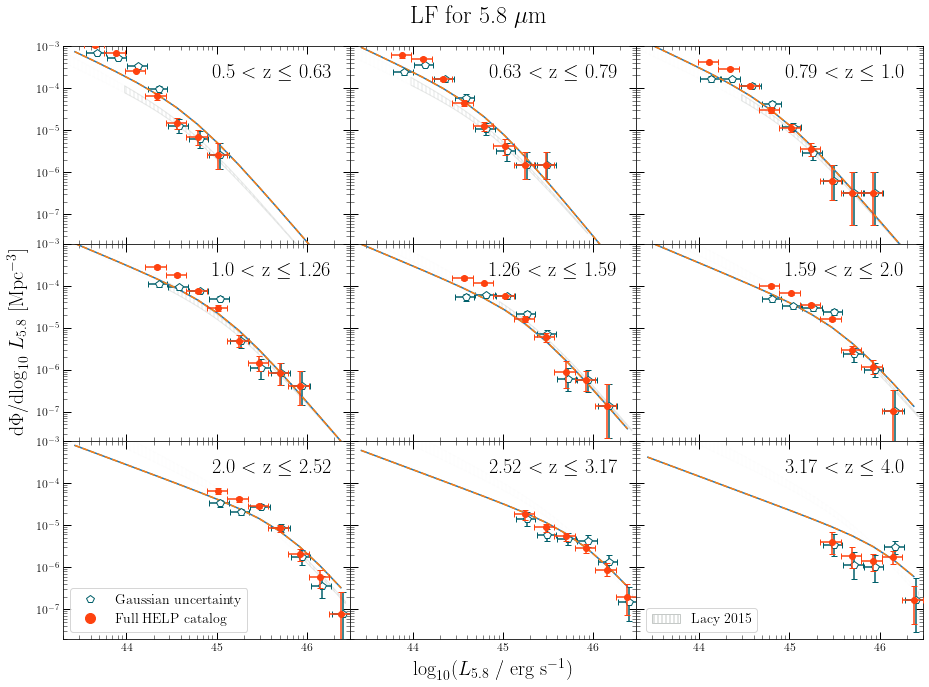

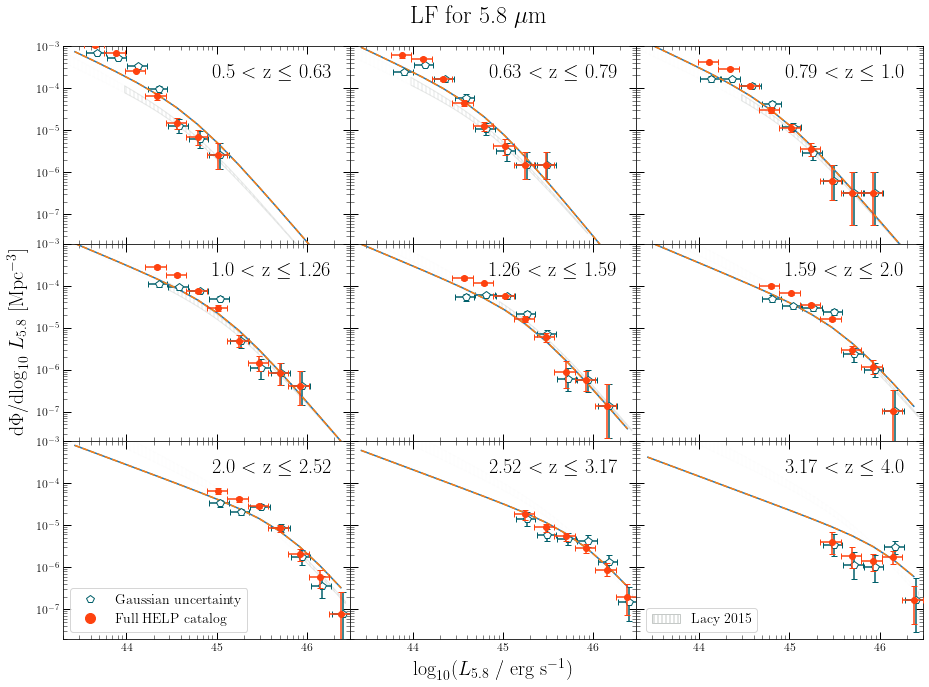

In [20]:
from scipy import odr
fig, axs, big_ax = vmax.plot_lf_vmax(mainruns[labels[0]][0], mainruns[labels[0]][1], z_bins, l_bins, compare_to_others=lit_data, other_runs=otherruns, lum_limits=l_limits, title=r'LF for 5.8 $\mathrm{\mu m}$', others_limits=other_limits, this_label=label, outfile='./output/paper_plots/' + outfile + '.pdf', lum_sublabel=r'_{5.8}')

def double_power_law(params, L):
    A, gamma1, gamma2, Lstar = np.array(params).astype(np.complex64)
    return A / ((L / Lstar)**gamma1 + (L / Lstar)**gamma2)

def double_power_law(params, L):
    A, gamma1, gamma2, Lstar = params.astype(complex)
#     if A > -4.0:
#         return 1e90
#     if gamma1 < 0:
#         return 1e90
#     if Lstar > 46.5:
#         return 1e90
    return (np.power(10, A) / ((L / 10**Lstar)**gamma1 + (L / 10**Lstar)**gamma2)).real


lum_errors = (l_bins[1:] - l_bins[:-1]) / 2
bin_centers = (l_bins[:-1] + l_bins[1:]) / 2

amps = np.array([-4.4, -4.4, -4.4, -4.5, -4.7, -4.9, -5.0, -5.2, -5.6])
gamma1s = np.array([1.0, 1.0, 1.0, 0.9, 0.9, 0.9, 0.8, 0.8, 0.8])
gamma2s = np.array([2.5, 2.6, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5])
Lstars = np.array([44.7, 44.8, 44.9, 45.1, 45.3, 45.6, 45.8, 45.9, 46.2])
param_list=np.array([amps, gamma1s, gamma2s, Lstars]).T
i = 0
j = 0
a = 0
for lf, lferr, ax in zip(mainruns[labels[0]][0], mainruns[labels[0]][1], axs):
    dpl = odr.Model(double_power_law)
    lferr[lferr == 0.0] = np.nan
#     mydata = odr.RealData(bin_centers, lf * bin_centers * np.log(10), sx=lum_errors, sy=1)
#     print(lf, lferr[1])
    mydata = odr.RealData(bin_centers, lf * bin_centers * np.log(10), sx=lum_errors, sy=lferr[1] * np.log(10) * bin_centers)
    myodr = odr.ODR(mydata, dpl, beta0=param_list[j], ifixb=[1, 1, 1, 1], maxit=200, stpb=[0.1, 0.01, 0.1, 1])
#     myodr = odr.ODR(mydata, dpl, beta0=[np.log10(6e-5) - a, 0.9, 2.7, np.log10(8e44)+i], ifixb=[1, 0, 0, 0], maxit=200, stpb=[0.1, 0.01, 0.1, 1])
    myoutput = myodr.run()
    
#     print(myoutput.beta)
    ax.plot(bin_centers, double_power_law(myoutput.beta, bin_centers))
#     ax.plot(bin_centers, double_power_law([np.log10(6e-5)-a, 0.9-i/10, 2.7, np.log10(8e44)+i], bin_centers))
    ax.plot(bin_centers, double_power_law(param_list[j], bin_centers), ls='--')
    i += .5/9
    j += 1
    a += 1.5/9

        
fig